# Lab 5: Non-negative Matrix Factorization

The goal of this lab session is to code a NMF algorithm and use it in some applications.

You have to send the filled notebook named **"NMF_familyname1_familyname2.ipynb"** (groups of 2) by email to *aml.centralesupelec.2020@gmail.com* a week from now and put **"NMF Lab"** in the subject. 

All questions will be graded unless it is explicitely indicated.

We begin with the standard imports:

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import check_random_state
from scipy.special import softmax
from tqdm import tqdm 

%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## NMF

Loss (Regularized Froebnius): $\mathcal{L}(D, S) = \frac{1}{2}\|X-D S\|_{F}^{2}+ \color{red}{\frac{\mu}{2}\|S\|_{F}^{2}+\lambda\|S\|_{1}+\frac{\nu}{2}\|D\|_{F}^{2}}$

Algorithm (multiplicative updates from [Lee and Seung, 1999]: 

\begin{array}{c}
D \leftarrow D \circ \frac{X S^{\top}}{D (S S^{\top} + {\color{red} \nu I_r})} \\
S \leftarrow S \circ \frac{D^{\top} X - {\color{red} \lambda 1_{r \times n}}}{(D^{\top} D + {\color{red} \mu I_r})S}
\end{array}

Fill in the following NMF class:

In [2]:
from scipy import linalg
class MYNMF():
    
    def __init__(self, n_components, random_state=42, max_iter=200):
        self.n_components_ = n_components
        self.max_iter_ = max_iter
        self.components_ = None    # shape (p, r)
        self.random_state = random_state
        self.epsilon_ = 1e-3
        self.error=None
    def fit_transform(self, data, mu=0.1, lambd=0., nu=0.):
        """ Find the parameters mu_ and Sigma_
        that better fit the data
        
        Parameters:
        -----------
        data: (p,n) np.array
               Data matrix
        
        Returns:
        -----
        embedding: (n, r) np.array
                    Embedding matrix        
        """        
        # TODO:
        # initialize both matrices
        
        # While not(convergence):
        #     Update D
        #     Update S
        
        # Return the embedding S.T
        
        p,n= data.shape
        ## initialize with svd 
        u, s, vh = np.linalg.svd(data, full_matrices=False)
        
        s_= np.diag(s[:self.n_components_]) ## take first r singular values 
        w0 = u[:,:self.n_components_] 
        h0 = s_ @ vh[:self.n_components_]
        
        self.components_=np.where(w0<0, 1e-3, w0)## replace negative values with epsilon = 1e-3
        embedding =np.where(h0<0, 1e-3, h0) ## replace negative values with epsilon = 1e-3
        
        i=0 
        while (i < self.max_iter_) and (np.linalg.norm (data - self.components_  @ embedding ) > self.epsilon_ ) : 
            
            self.components_ = self.components_ * ((data @ embedding.T)/(self.components_ @ (embedding @ embedding.T+nu*np.eye(self.n_components_))))
            reg = self.components_.T @ self.components_ + mu*np.eye(self.n_components_)
            embedding = embedding* ((self.components_.T @ data - lambd) / (reg @ embedding))
            
            i+=1
        self.error = np.linalg.norm (data - self.components_  @ embedding )        
        return embedding.T
    
    
    def inverse_transform(self, embedding):
        """ Maps an embedding matrix into the original space. 
        
        Parameters:
        -----------
        embedding : (n, r) np.array
                     Embedding matrix
        
        Returns:
        -----
        data_hat : (p,n) np.array  
                   reconstructed data matrix
        """       
        data_hat = self.components_ @ embedding.T

        return data_hat

    def predict_label(self, X): 
        """ Predict labelsfor X : cluster hard-assignment
        
        Parameters:
        -----------
        X: (p,n) np.array
           data matrix
        
        Returns:
        -----
        label assignment : (n, ) np.array
                          Its elements are the predicted classes, from 0 to r-1
        # TODO        """        
                  
        embed_new = self.components_.T @ X
        return np.argmax(embed_new.T,1)
        
    def predict_proba(self, X):
        """ Predict probabilities of different classes for X :  cluster soft-assignment
        
        Parameters:
        -----------
        X: (p, n) np.array
            New data matrix
        
        Returns:
        -----
        label assignment : (n, r) np.array
                          Its elements are the probabilities for different classes
        """
        # TODO
        embed_new = self.components_.T @ X
        return softmax(embed_new.T,axis=1)

### Remark :
Normally, the S matrix is obtained for new samples by solving an optimization problem ( as probably done in sklearn, in the **transform** method). In fact, $S_{new}$ should be the argmin of the error function $\|X_{new}-D S\|$ , with D obtained by the fit function. So to avoid implementing scikit function, I did the approximation that $$ S_{new} = D^{T} X_{new} $$ 

In [9]:
# Find best hyperparameters 
d={}
tab_mu = [0. , 0.1 , 0.01]
tab_lambda= [0,0.1,0.01]
tab_nu = [0,0.1,0.01]
for mu in tqdm(tab_mu,total=3) :
    for nu in tab_nu :
        for lambd in tab_lambda :
            n_components = 100
            nmf_instance = MYNMF(n_components = n_components  ,max_iter=50)
            _=nmf_instance.fit_transform(faces.T, mu=mu, lambd=lambd , nu=nu)
            d[(mu,nu,lambd)]=nmf_instance.error
            
print(max(d, key=(lambda key: d[key])))        

100%|██████████| 3/3 [02:00<00:00, 40.26s/it]

(0.1, 0, 0)


So the best values for our hyperparameters are : $\mu = 0.1 , \lambda = 0 , \nu=0 $

In [11]:
## Finetune r parameter 

possible_r=np.linspace(20,400,20)
tab_errors=[]
for r in tqdm(possible_r,total=len(possible_r)):
    nmf_instance = MYNMF(n_components = int(r) , max_iter=50)
    _=nmf_instance.fit_transform(faces.T, mu=mu, lambd=lambd , nu=nu)
    tab_errors.append(nmf_instance.error)

100%|██████████| 20/20 [01:37<00:00,  4.85s/it]


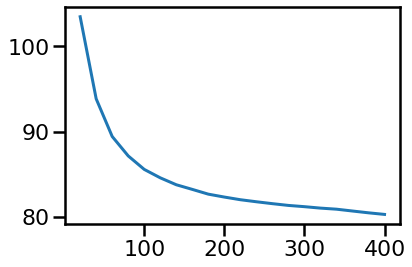

In [12]:
plt.plot(possible_r,tab_errors)

A value of $ r \sim 250 $ is a good compromise between minimizing the loss norm and reducing the number of atoms. 
We take r = 225  since it's a perfect square and we need to plot W in a $(\sqrt{r}, \sqrt{r})$ grid later on.

## Applications

### First application

For the first application you are going to analyse the following data to give an interpretation of the factorization:

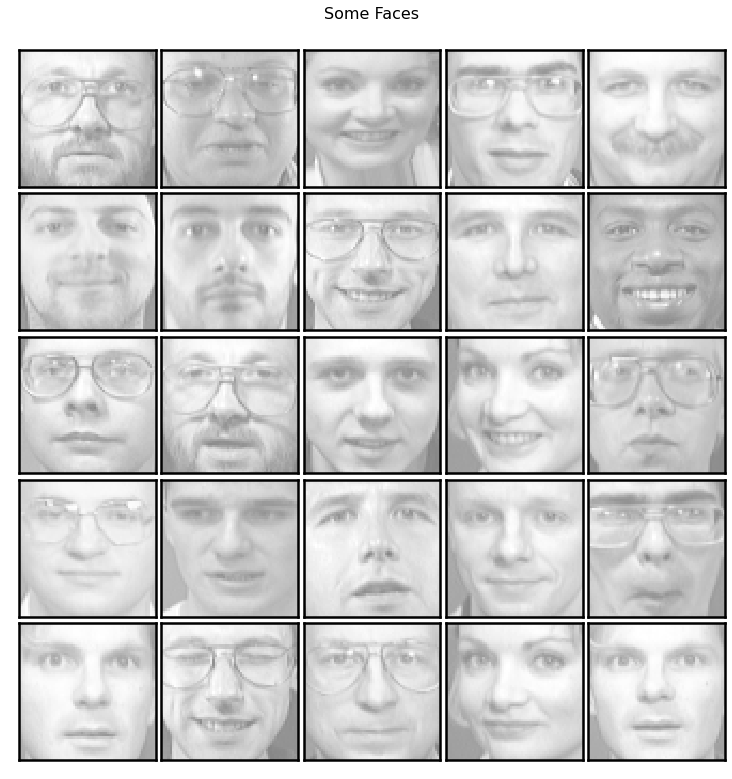

In [6]:
from sklearn.datasets import fetch_olivetti_faces


dataset = fetch_olivetti_faces(shuffle=True)

faces = dataset.data  # n = 400 flattened images of p = 4096 = 64 x 64
image_shape = (64, 64)

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

def plot_gallery(images, image_shape, title='', cmap=plt.cm.gray):
    # fit the nb of images into a square
    n_images = len(images)
    nrows = int(np.ceil(np.sqrt(n_images)))
    ncols = nrows
    
    # instantiate figure
    fig, axes = plt.subplots(nrows, ncols, figsize=(2. * ncols, 2.26 * nrows))
    fig.suptitle(title, size=16)
    
    axes_for_display = axes.flatten()[:n_images]
    axes_to_blank = axes.flatten()[n_images:]
    
    for idx, comp in enumerate(images):
        ax = axes_for_display[idx]
        vmax = max(comp.max(), -comp.min())
        ax.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        ax.set(xticks=(),
               yticks=())
        
    for ax in axes_to_blank:
        ax.axis('off')

    fig.tight_layout()
    fig.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)  # insert space below the suptitle
    

plot_gallery(title="Some Faces", 
             images=faces[:25], 
             image_shape=image_shape)


Apply *your* NMF algorithm for this dataset and plot the approximated face pictures.

- Plot the $W$ matrix as images in a $(\sqrt{r}, \sqrt{r})$ grid
- Explain how to interpret both matrices W and H.
- Discuss the results you have obtained
- Conduct a critical analysis of your choice. Concretely, choose an aspect or two of the NMF method (e.g. Loss, Clustering, Geometry of the Embedding Space, Choice of the number of components r, any other of your choice), write code for it, test it, present (a) figure(s), and discuss. 

First we plot reconstructions 

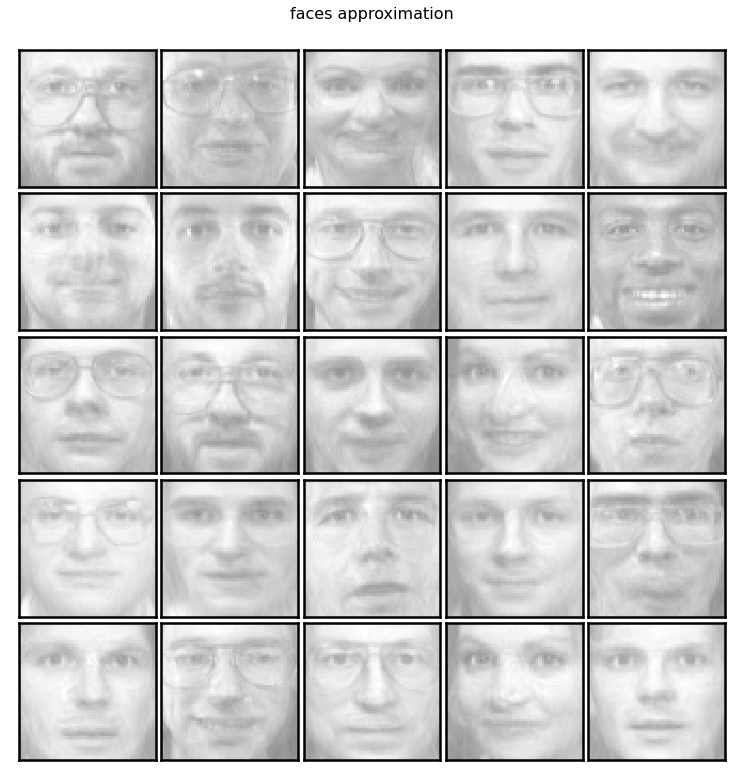

In [67]:
## Define parameters
n_components = 225

nmf_instance = MYNMF(n_components = n_components  ,max_iter=250)
embedding=nmf_instance.fit_transform(faces.T, mu=0, lambd=0 , nu=0)
faces_approx=nmf_instance.inverse_transform(embedding)

plot_gallery(title="faces approximation", images=faces_approx.T[:25], image_shape=image_shape)


We have a good reconstruction to the face pictures. 

Now we plot $W$ in a $(\sqrt{r}, \sqrt{r})$ grid


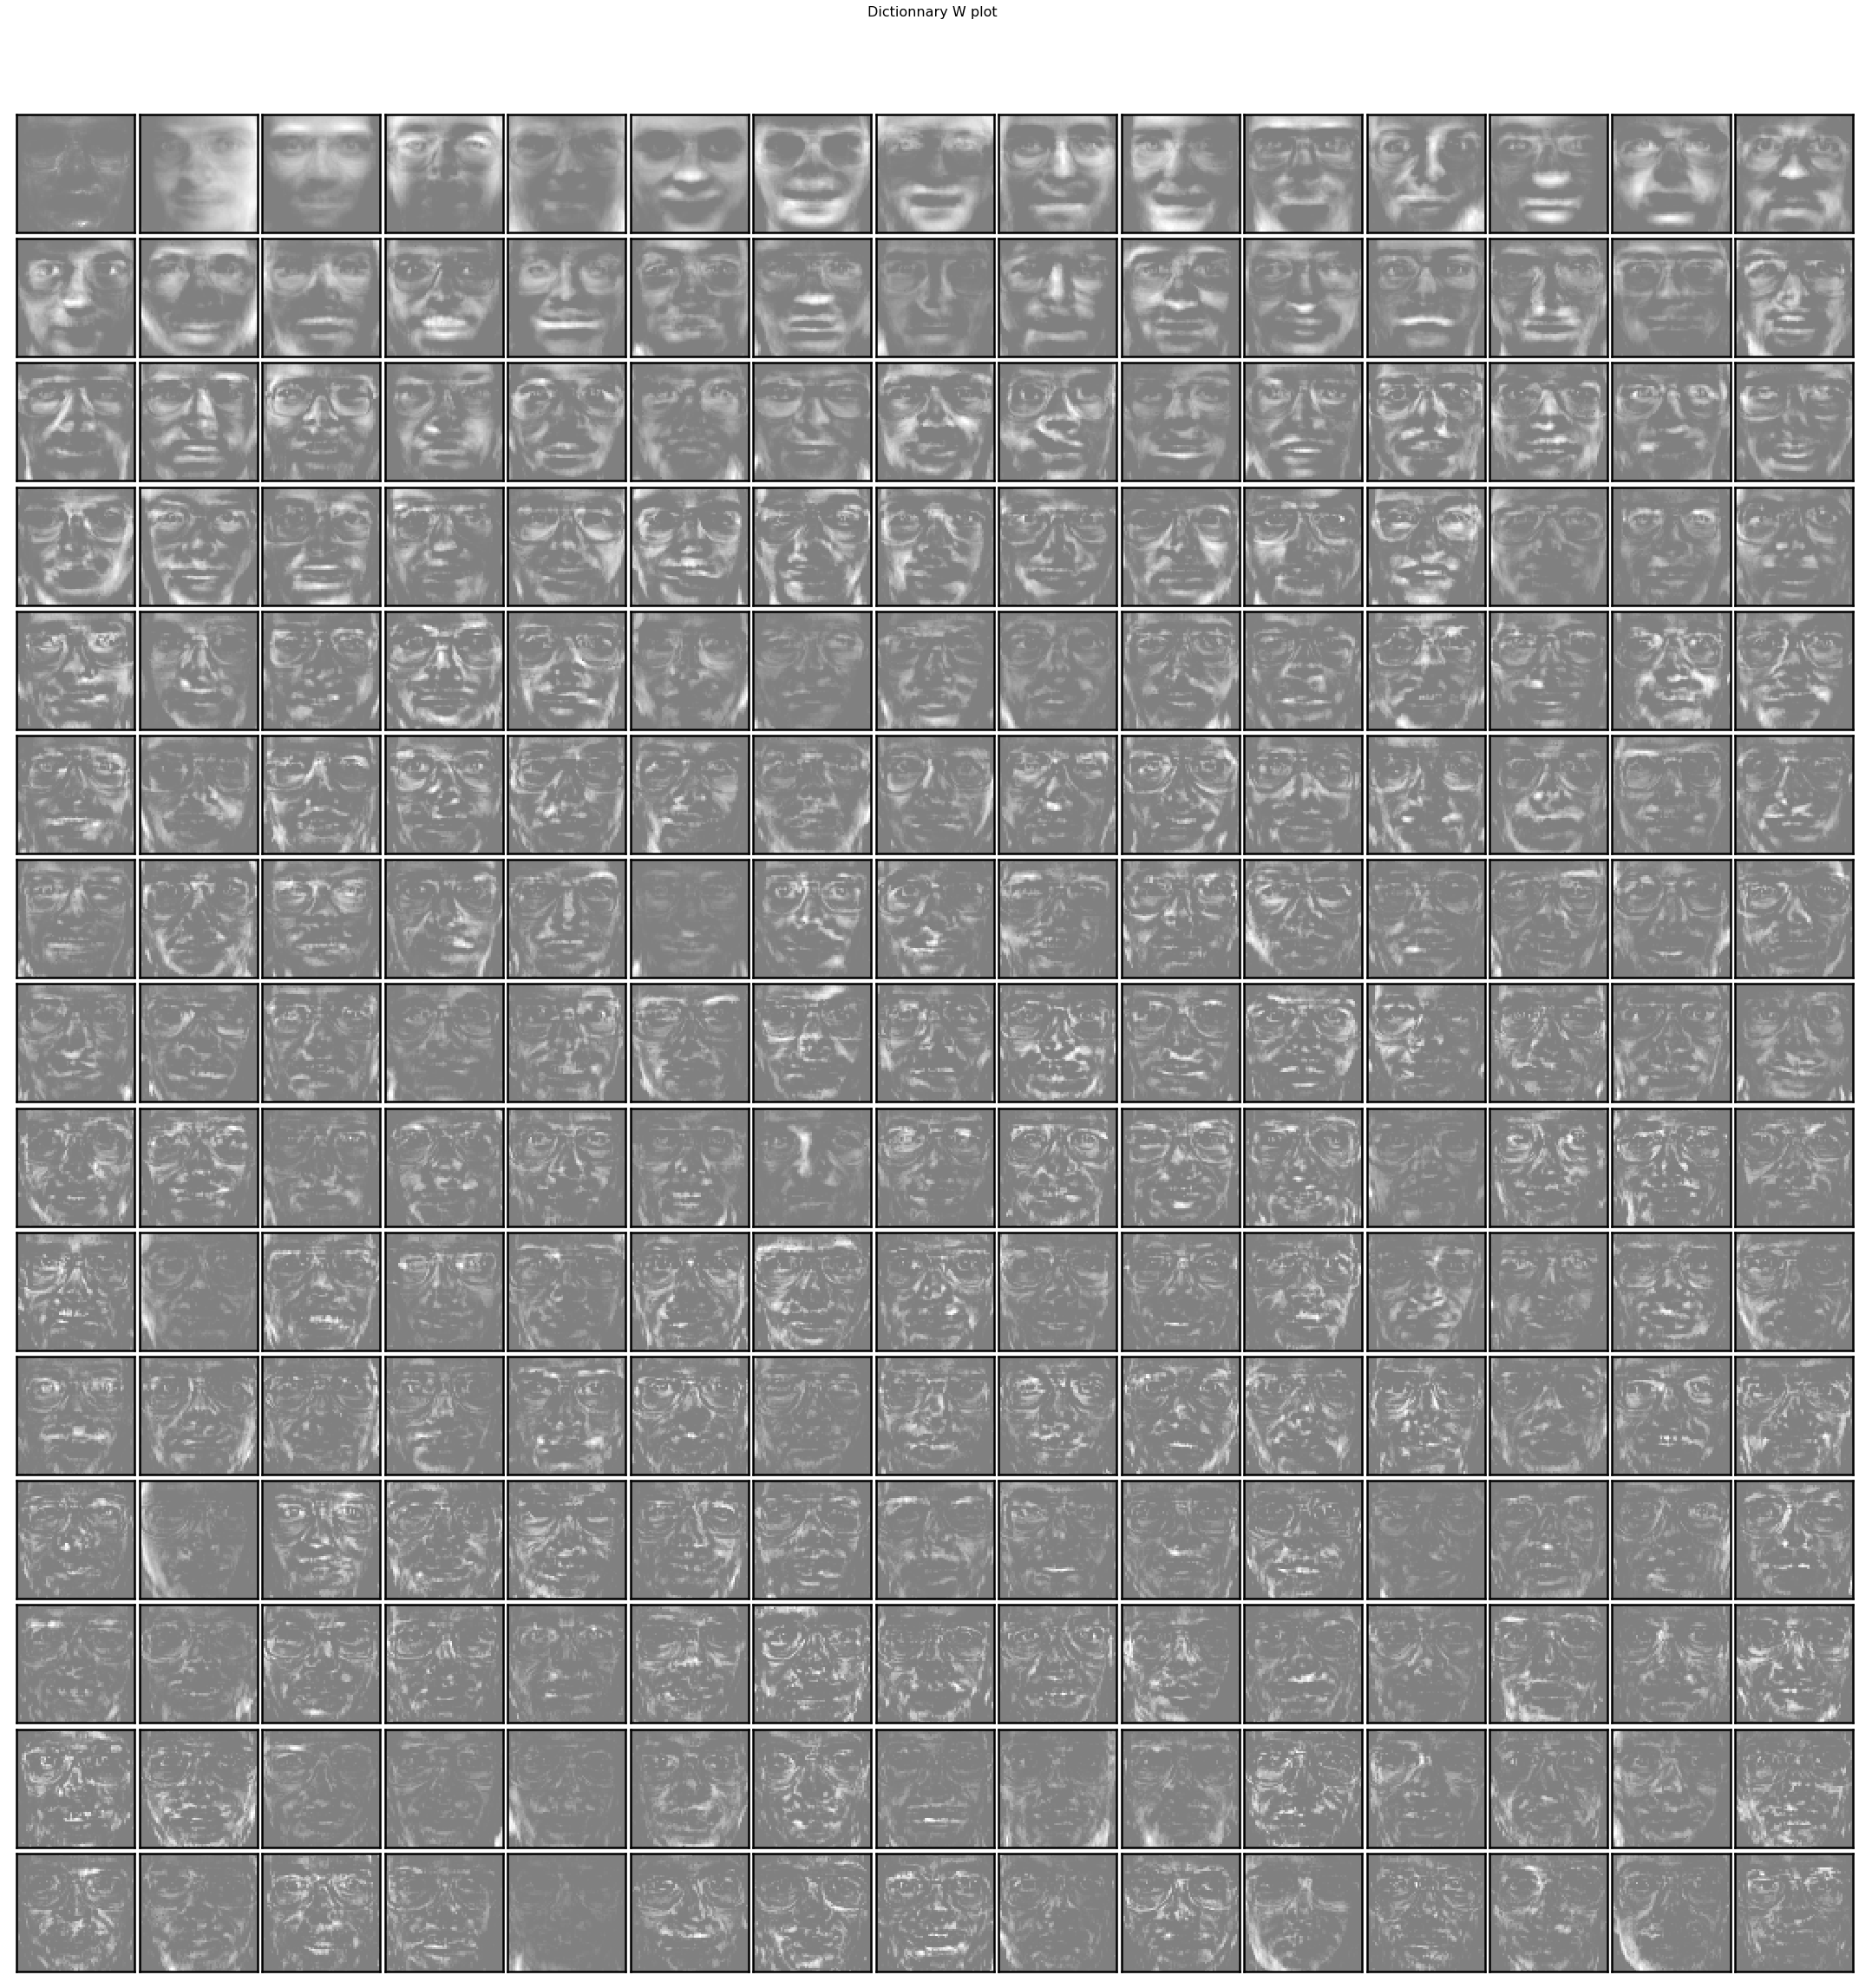

In [50]:
plot_gallery(title="Dictionnary W plot ",images=nmf_instance.components_.T,image_shape=image_shape)

We see that the atoms of $W$ represent some face patterns. In fact each atom emphasize on a particular part of the face ( example mouth , smile , moustache for men , eyglasses ,etc ... ) but some other atoms take the form of an entire from the training set. This may not be interesting because we want our latent variables to represent certain **global** features such as contours and edges. A solution to this might be to reduce r , in order to force the representation by the atoms to keep the most intersting features. 

Now we plot the weights in H for the first image as a heatmap : the darkest pixels are the lowest in values. 

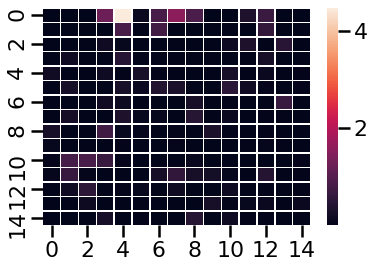

In [68]:
j=1
r_sqrt=int(np.sqrt(nmf_instance.n_components_))
#plt.imshow(nmf_instance.H_[:,j].reshape(r_sqrt,r_sqrt),cmap='hot')
ax = sns.heatmap(nmf_instance.embedding_[j,:].reshape(r_sqrt,r_sqrt), linewidth=0.5)
plt.show()

We observe that atom $W_{5}$ "generates" many patterns of the first image , because the coefficient $H_{5,1}$ is important. Furthermore, our image can expressed as a linear combination of a few atoms, since many coefficients of $H_{1}$ are close to zero.

Here we will plot the 5 first atoms that contribute to the representation of an image j , i.e where $h_{j,k}$ is the biggest ( correspond to bright pixels above ). 

In [69]:
## Plot the 5 first atoms 

def plot_best_atoms (k,nmf_instance) :
    fig , axes =plt.subplots(2,3)
    axes[0][0].imshow(faces[k].reshape(64,64),cmap='gray')
    axes[0][0].set_yticklabels([])
    axes[0][0].set_xticklabels([])
    axes[0][0].axis('off')

    top_5_indexes = nmf_instance.embedding_[k,:].argsort()[-5:][::-1]
    k=0
    for i in range(2) :
        for j in range(3) :
            if i ==0 and j==0 :
                continue

            image=nmf_instance.components_.T[top_5_indexes[k]]
            vmax = max(image.max(), -image.min())
            axes[i][j].imshow(image.reshape(image_shape),
                              interpolation='nearest',cmap=plt.cm.gray,vmin=-vmax, vmax=vmax)
            k+=1
            axes[i][j].set_yticklabels([])
            axes[i][j].set_xticklabels([])
            axes[i][j].axis('off')

    plt.show()    

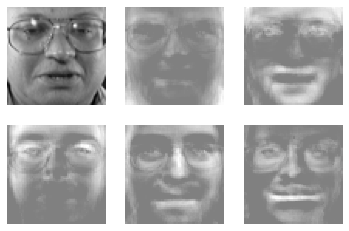

In [70]:
plot_best_atoms(k=1,nmf_instance=nmf_instance) 

Since we have many atoms, we observe that the image is not well "explained" by the 5 best atoms. So it might be interesting to reduce the number of components $r$ so that an image can be entirely explained by few features. 

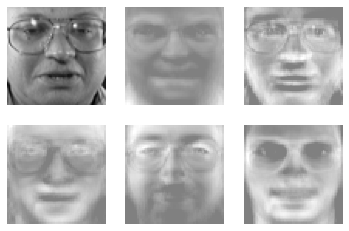

In [72]:
n_components = 25

nmf_instance_2 = MYNMF(n_components = n_components , max_iter=300)
embedding=nmf_instance_2.fit_transform(faces.T, mu=0, lambd=0 , nu=0)

plot_best_atoms(k=1,nmf_instance=nmf_instance_2) 

Here the atoms are more expressive : our image is clearly explained by atoms that have the same face contour, sunglasses,mouth expression,etc... So reducing the parameter r resulted in more expressive atoms that contain the most important features of the images (face contour and edges , smile type , with or without sunglasses,etc ...) 

### Second application

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 newsgroup documents from 20 different newsgroups.

Model the topics present in a subsample with *scikit-learn's* NMF. Print the most common words of each topic. 

Discuss.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20


def print_top_words(D, feature_names, n_top_words):
    p, r = D.shape
    for topic_idx in range(r):
        topic = D[:, topic_idx]
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))

data_samples = dataset.data[:n_samples]


# Use tf-idf features for NMF.
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data_samples).toarray()

# Fit the NMF model, print top words
n_components = 10
nmf_instance = MYNMF(n_components = n_components  ,max_iter=300)
_=nmf_instance.fit_transform(tfidf.T)
feature_names = list({k: v for k, v in sorted(tfidf_vectorizer.vocabulary_.items(), key=lambda item: item[1])}.keys())

print_top_words(nmf_instance.components_, feature_names, n_top_words)


Topic #0: send david let ftp remember want box mail news bob simple posted current thank reply net cs post working place
Topic #1: god people say think just jesus bible did believe don law life way really point christians agree christian fact make
Topic #2: year car ll years like got team just game way probably government great good going couple better won time right
Topic #3: use windows key using file government problem chip encryption dos keys clipper program window work used make public help law
Topic #4: god year game 10 new good time windows drive 00 11 great team 15 jesus version power 20 software sale
Topic #5: know like does don thanks windows just game ve think hi anybody win mean file help info advance sounds maybe
Topic #6: thanks does car new know drive advance chip interested power used price email key card speed hard bike hi cars
Topic #7: just edu don want like car bike drive need soon work problem think stuff good buy look try thing power
Topic #8: drive think drives p

/home/hamza/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


In [5]:
new_data_sample = dataset.data[2036]  # unseen
print(new_data_sample)


Didn't Paul write that if the Resurrection is not true, we are the
biggest fools of all?  However, whether you believe in Christ or not,
His teachings (e.g. love your brotherman as yourself), even if only 
followed at a secular level, could do a great deal to alleviate some of 
the problems we see today in the world.  Even when I was a rabid atheist 
I couldn't deny that.


With which topics does the nmf model best associate this new sample? Does it make sense? What about another new sample?

How does this NMF method compare to other embedding methods you know in NLP?

In [6]:
## For new sample 
tfidf_new = tfidf_vectorizer.transform([new_data_sample]).toarray()
print('Tab of probabilities is :',nmf_instance.predict_proba(tfidf_new.T)[0])

Tab of probabilities is : [0.09415305 0.11076401 0.10100675 0.09780024 0.10397833 0.09709406
 0.09498025 0.09685154 0.0994814  0.10389038]


Here the probabilities are close to each other , but we can distinguish two main topics : topic 1 and topic 4. If we explore our text sample we can se that it talks about religion , which is the theme of topic 1 and 4 . 

Now we will compare NMF with LDA to see if the topics generated are more relevant. 

In [24]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=10,max_iter=250)
lda.fit(tfidf)
print_top_words(lda.components_.T, feature_names, n_top_words)


Topic #0: people don just like think know god good time way new really say did make does right car use want
Topic #1: luck test comp site mark let good effective talking library trying post phone bought city cases au ftp agree reply
Topic #2: key clipper chip encryption keys thanks does advance public uk interested case secure know info going email encrypted faq company
Topic #3: pub deleted just cubs wondering got guess jewish stuff supposed subject couldn bit consider non wanted oh 22 right robert
Topic #4: edu marriage armenians insurance greek armenian com navy changed armenia ibm soon 800 bob parents didn article azerbaijan apartment buying
Topic #5: windows thanks file use software drive edu card mail using need help problem know pc email computer window does like
Topic #6: turkish meaning wrong ll sure rest value license road greek just anti listen matter going folks jews long appears didn
Topic #7: game team games 00 season win toronto year division mike nhl teams players runs 

We can observe that the topics generated by LDA are more diverse. For instance, we have one topic on religion (0) one on sport (7 ) , one computer science (5),etc... 
Now, let's predict the topics of our new sample. 

In [25]:
H_new= lda.transform(tfidf_new)
print('Tab of probabilities is :',softmax(H_new,axis=1)[0])

Tab of probabilities is : [0.19638106 0.08929095 0.08929089 0.08929115 0.08929102 0.08929119
 0.08929093 0.08929104 0.08929089 0.08929089]


Here we can distinguish one main topic : topic #1. We can see that the most important words of this topic express morality and religion , which corresponds to our sample. 
More generally ,LDA adds a Dirichlet prior on top of the data generating process so we have a probabilistic process that explains the generation of data , whereas NMF is a deterministic model. Thus , the lda offers more flexibility and expresses uncertainty better about the assignment of words to topics . This results in a more robust and better mixtures. 